Epoch 1/35, Loss: 0.6941
Epoch 2/35, Loss: 0.6936
Epoch 3/35, Loss: 0.6907
Epoch 4/35, Loss: 0.6761
Epoch 5/35, Loss: 0.6235
Epoch 6/35, Loss: 0.5950
Epoch 7/35, Loss: 0.5650
Epoch 8/35, Loss: 0.5670
Epoch 9/35, Loss: 0.5408
Epoch 10/35, Loss: 0.4811
Epoch 11/35, Loss: 0.4266
Epoch 12/35, Loss: 0.4026
Epoch 13/35, Loss: 0.3441
Epoch 14/35, Loss: 0.3588
Epoch 15/35, Loss: 0.3738
Epoch 16/35, Loss: 0.2616
Epoch 17/35, Loss: 0.2482
Epoch 18/35, Loss: 0.1890
Epoch 19/35, Loss: 0.1488
Epoch 20/35, Loss: 0.1147
Epoch 21/35, Loss: 0.0900
Epoch 22/35, Loss: 0.1031
Epoch 23/35, Loss: 0.1397
Epoch 24/35, Loss: 0.0455
Epoch 25/35, Loss: 0.0654
Epoch 26/35, Loss: 0.0812
Epoch 27/35, Loss: 0.0385
Epoch 28/35, Loss: 0.0139
Epoch 29/35, Loss: 0.0161
Epoch 30/35, Loss: 0.0058
Epoch 31/35, Loss: 0.0032
Epoch 32/35, Loss: 0.0025
Epoch 33/35, Loss: 0.0022
Epoch 34/35, Loss: 0.0019
Epoch 35/35, Loss: 0.0017


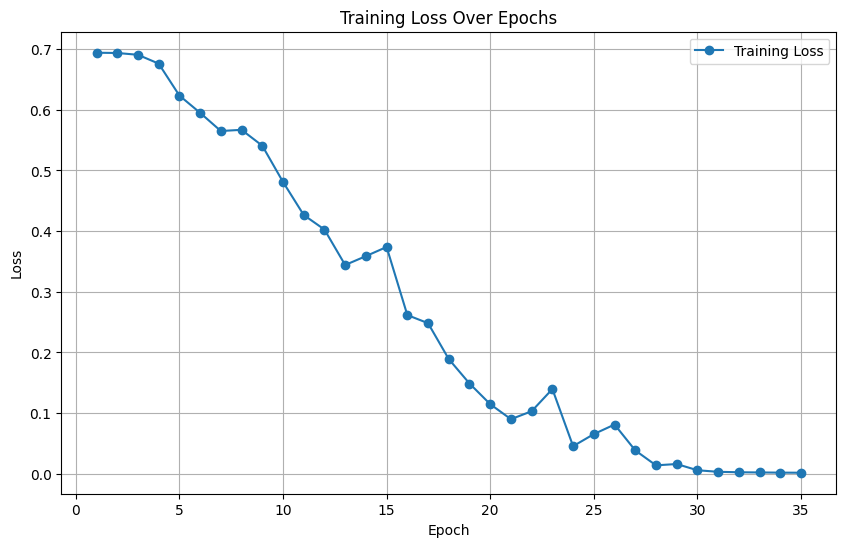

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

class DatingPreferenceModel(nn.Module):
    def __init__(self, embedding_dim):
        super(DatingPreferenceModel, self).__init__()
        self.candidate_embedding = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        self.user_embedding = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # Финальный классификатор
        self.classifier = nn.Sequential(
            nn.Linear(64 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, candidate1, candidate2, user):
        # Обработка эмбеддингов кандидатов и пользователя
        c1_embed = self.candidate_embedding(candidate1)
        c2_embed = self.candidate_embedding(candidate2)
        user_embed = self.user_embedding(user)

        combined = torch.cat([c1_embed, c2_embed, user_embed], dim=1)
        
        output = self.classifier(combined)
        return output

class PreferenceDataset(Dataset):
    def __init__(self, num_samples, embedding_dim):
        self.candidate1 = np.random.rand(num_samples, embedding_dim).astype(np.float32)
        self.candidate2 = np.random.rand(num_samples, embedding_dim).astype(np.float32)
        self.user = np.random.rand(num_samples, embedding_dim).astype(np.float32)
        self.labels = np.random.randint(0, 2, size=(num_samples,)).astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (self.candidate1[idx], self.candidate2[idx], self.user[idx], self.labels[idx])

# Функция обучения модели

def train_model(model, dataloader, optimizer, criterion, device, num_epochs):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        total_loss = 0
        for candidate1, candidate2, user, labels in dataloader:
            candidate1, candidate2, user, labels = candidate1.to(device), candidate2.to(device), user.to(device), labels.to(device)
        
            optimizer.zero_grad()
            outputs = model(candidate1, candidate2, user)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        epoch_loss = total_loss / len(dataloader)
        loss_history.append(epoch_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    
    return loss_history

# Функция для дообучения модели

def fine_tune_model(model, dataloader, optimizer, criterion, device):
    model.train()
    for candidate1, candidate2, user, labels in dataloader:
        candidate1, candidate2, user, labels = candidate1.to(device), candidate2.to(device), user.to(device), labels.to(device)
    
        optimizer.zero_grad()
        outputs = model(candidate1, candidate2, user)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

# Пример использования
if __name__ == "__main__":
    # Параметры
    embedding_dim = 300  # Размер эмбеддинга
    num_epochs = 35      # Количество эпох
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = DatingPreferenceModel(embedding_dim).to(device)

    # Оптимизатор и функция потерь
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    train_dataset = PreferenceDataset(num_samples=1000, embedding_dim=embedding_dim)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    loss_history = train_model(model, train_dataloader, optimizer, criterion, device, num_epochs)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), loss_history, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

